# Plume Analysis DBScan

In [88]:
%matplotlib inline
from IPython.display import display, Markdown
import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal
import matplotlib.ticker as mticker
import math
from IPython.display import display, Latex
import statistics
import plotly.express as px
import hvplot.pandas
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

In [89]:
# %config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.
plt.rcParams['figure.dpi'] = 100

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

In [90]:
R0 = 2870000.0; # m
rho0 = 3300 # kg/m^3
g0 = 9.8 # m/s^2
alpha = 5e-5 # 1/K
eta = 10**20 # Pa s
cp = 1250 # J/(kg K)
kappa = 1e-6; # m^2/s
k = kappa*rho0*cp; # W/m

def deltaT(Ra):
    tt = (Ra*eta*kappa)/(rho0*g0*alpha*R0**3)
    return tt

In [91]:
def plume_analysis_new(df):
    vel_mag = (df['velocity:0']**2 + df['velocity:1']**2 + df['velocity:2']**2)
    data_Y=df['Points:1'].values; data_Z=df['Points:2'].values #not height
    dim=int(np.sqrt(len(df['temperature'])))
    T_blocks = np.reshape(df['temperature'].to_numpy(),(dim,dim))
    U_blocks = np.reshape(df['velocity:0'].to_numpy(),(dim,dim))
    U_mag = np.reshape(vel_mag.to_numpy(),(dim,dim))
    Y_blocks = np.reshape(df['Points:1'].to_numpy(),(dim,dim)); Z_blocks = np.reshape(df['Points:2'].to_numpy(),(dim,dim))
 
    max_temp=np.max(T_blocks); avg_temp=np.mean(T_blocks); thd_temp=avg_temp+0.2*(max_temp-avg_temp)

    P_blocks=np.zeros((dim,dim)) #Location of plumes. 1 = plume, 0 = no plume
    T_p_blocks=np.zeros((dim,dim)) #Only plume temperature. 1 = plume, 0 = no plume
    P_blocks[:] = np.nan; T_p_blocks[:] = np.nan;
    
    da=(data_Y[1]-data_Y[0])**2 #area

    pmf=0; phf=0; plume_temp=[]; plume_cells=0; ypoints1 = []; zpoints2 = []; vmag = []; vz = [];

    for i in range(dim-1):
        for j in range(dim-1):
            if (T_blocks[i,j]>=thd_temp) and (U_blocks[i,j]>0):
                plume_cells+=1
                plume_temp.append(T_blocks[i,j])
                ypoints1.append(Y_blocks[i,j])
                zpoints2.append(Z_blocks[i,j])
                vmag.append(U_mag[i,j])
                vz.append(U_blocks[i,j])
                P_blocks[i,j]=1
                T_p_blocks[i,j] = T_blocks[i,j]
                pmf+=U_blocks[i,j]*da
                phf+=U_blocks[i,j]*(T_blocks[i,j]-avg_temp)*da

    plume_temp_mean=np.sum(plume_temp)/plume_cells
    maxTp = np.max(plume_temp); minTp = np.min(plume_temp); sd = statistics.stdev(plume_temp)
    return maxTp, plume_temp_mean, plume_temp, P_blocks, T_p_blocks, dim, minTp, sd, ypoints1, zpoints2, vmag, vz

In [119]:
save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
overshootData = pd.read_csv(save_path+'overshoot_data.csv')

def myround(x, prec=3, base=0.005):
    return round(base * round(x/base),prec)

depth_float = myround(overshootData['Depth'])*1000
depth_file = [str(int(z)) for z in depth_float]
depth_file.append('995'); depth_file.append('995')

In [120]:
plume_path = '\\Plume Data'

main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'
fname = os.path.join(main_path,'[!m]*'); fileL = glob.glob(fname) #list of files
fileL = [file.replace(main_path,'') for file in fileL]
[fileL.remove(file) for file in fileL if '_' in file]; [fileL.remove(file) for file in fileL if 'Plume' in file];
ra_path = sorted (fileL, key = lambda x: (len (x), x)); lenRa = len(ra_path)

Data = pd.DataFrame()

for i in range(lenRa): 
    if i == 0:
        fname = os.path.join(main_path+ra_path[i]+'\\Plume Data','700.csv')
    else:
        fname = os.path.join(main_path+ra_path[i]+'\\Plume Data',depth_file[i]+'.csv')
    fileL = glob.glob(fname) #list of files
    temp = []
    for file in fileL:
        a = fileL.index(file)
        b = pd.read_csv(file,header=0); b.rename(columns={0:a}, inplace=True); temp.append(b)
    c = b['temperature'].copy(); c.values[:] = ra_path[i]; temp.append(c)
    my_data = pd.concat(temp, axis=1, join="inner",ignore_index=True).drop([4],axis=1)
    my_data.rename(columns={0:'temperature',5:'Points:1',6:'Points:2',7:'Ra',1:'velocity:0',\
                            2:'velocity:1',3:'velocity:2'},inplace=True)
    Data = pd.concat([Data,my_data],ignore_index=True)
Data['Ra'] = Data['Ra'].astype(float)
Data = Data.sort_values(by=['Ra','Points:2','Points:1'])
Data = Data.reset_index(drop=True)

In [121]:
RaU = Data.Ra.unique()

data = [[] for i in range(lenRa)] #empty nested list

for i in range(lenRa):
    data[i] = Data.loc[Data['Ra'] == RaU[i]]
    data[i] = data[i].reset_index(drop=True)
    
plumeData = pd.DataFrame(columns=['Ra', 'Z', 'T_p'],index=range(0, lenRa))
temperature_data = [[] for i in range(lenRa)] #empty nested list
x_data = [[] for i in range(lenRa)] #empty nested list
y_data = [[] for i in range(lenRa)] #empty nested list
vMag = [[] for i in range(lenRa)]; vZ = [[] for i in range(lenRa)]; area_total = [[] for i in range(lenRa)]


for i in range(lenRa):
    if i == 0:
        plumeData.at[i, 'Ra'] = RaU[i]; plumeData.at[i, 'Z'] = 0.7
    else:
        plumeData.at[i, 'Ra'] = RaU[i]; plumeData.at[i, 'Z'] = float(depth_file[i])/1000
    pa = plume_analysis_new(data[i])
    plumeData.at[i, 'T_p'] = pa[1]
    plumeData.at[i, 'max_T_p'] = pa[0]; plumeData.at[i, 'min_T_p'] = pa[6]
    plumeData.at[i, 'Std. Dev.'] = pa[7]
    temperature_data[i] = pa[2]
    x_data[i] = pa[8]; y_data[i] = pa[9]
    vMag[i] = pa[10]; vZ[i] = pa[11]; area_total[i] = pa[5]**2

In [122]:
plumeData

,Ra,Z,T_p,max_T_p,min_T_p,Std. Dev.
0,10000.0,0.7,0.657259,0.83173,0.57566,0.069917
1,100000.0,0.87,0.671328,0.86980,0.58902,0.074624
2,1000000.0,0.94,0.680373,0.91536,0.60051,0.078859
3,3000000.0,0.95,0.592889,0.67651,0.48662,0.058944
4,10000000.0,0.965,0.632485,0.75935,0.57350,0.043249
5,30000000.0,0.975,0.637669,0.86152,0.50754,0.081076
6,100000000.0,0.98,0.624303,0.85716,0.57316,0.060054
7,300000000.0,0.99,0.636683,0.81899,0.60009,0.035846
8,600000000.0,0.99,0.650081,0.82314,0.58960,0.044525
9,1000000000.0,0.99,0.600873,0.77998,0.55877,0.044160


In [123]:
labels = [[] for i in range(lenRa)]; plume_areas = [[] for i in range(lenRa)]; plume_area_ave = [[] for i in range(lenRa)];
plume_location = [[] for i in range(lenRa)]; plume_data_final = [[] for i in range(lenRa)] 
meanPlumeTemp = [[] for i in range(lenRa)]
meanPlumeSpeed = [[] for i in range(lenRa)]; meanPlumeZ = [[] for i in range(lenRa)]

for q in range(lenRa):
    plume_location[q] = pd.DataFrame(np.vstack((x_data[q], y_data[q])).T)

for i in range(lenRa):
    dbscan = DBSCAN(eps = 0.006, min_samples = 3).fit(plume_location[i]) # fitting the model
    labels[i] = dbscan.labels_ # getting the labels
    plume_data_final[i] = plume_location[i]
    plume_data_final[i]["class"] = labels[i]
    plume_data_final[i] = plume_data_final[i][plume_data_final[i]['class'] != -1]
    num_of_plumes = np.max(np.unique(labels[i])) + 1
    plume_areas[i] = list(Counter(plume_data_final[i]['class']).values())
    plume_area_ave[i] = np.mean(plume_areas[i])/area_total[i]
    
    for m in range(num_of_plumes):
        idx = np.where(labels[i]==m)[0]
        ptemp = np.array(temperature_data[i]); pspeed = np.array(vMag[i])
        pZ = np.array(vZ[i])
        meanPlumeTemp[i].append(ptemp[idx].mean())
        meanPlumeSpeed[i].append(pspeed[idx].mean()); 
        meanPlumeZ[i].append(pZ[idx].mean())

In [124]:
plumeDataCluster = pd.DataFrame(columns=['Ra', 'Number', 'Mean T', 'STDEV','Max T', 'Min T',\
                                         'Speed', 'Z Speed', 'Thickness'],index=range(0, lenRa))
plumeDataCluster['Ra'] = RaU
for q in range(lenRa):
    plumeDataCluster['Number'][q] = len(meanPlumeTemp[q])
    plumeDataCluster['Mean T'][q] = np.mean(meanPlumeTemp[q])
    plumeDataCluster['STDEV'][q] = np.std(meanPlumeTemp[q])
    plumeDataCluster['Max T'][q] = np.max(meanPlumeTemp[q])
    plumeDataCluster['Min T'][q] = np.min(meanPlumeTemp[q])
    plumeDataCluster['Speed'][q] = np.min(meanPlumeSpeed[q])
    plumeDataCluster['Z Speed'][q] = np.min(meanPlumeZ[q])
    plumeDataCluster['Thickness'][q] = np.min(plume_area_ave[q])

save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
plumeDataCluster.to_csv(save_path+'single_plume_data_overshoot.csv', index=False)
plumeDataCluster

,Ra,Number,Mean T,STDEV,Max T,Min T,Speed,Z Speed,Thickness
0,1.000000e+04,2,0.657254,0.000493,0.657747,0.656761,1787.829333,36.261476,0.165158
1,1.000000e+05,2,0.671318,0.000797,0.672115,0.670521,35245.533309,127.472093,0.093847
2,1.000000e+06,2,0.680358,0.00107,0.681428,0.679289,625109.336272,335.220581,0.063703
3,3.000000e+06,1,0.592889,0.0,0.592889,0.592889,3099584.648822,108.864865,0.402762
4,1.000000e+07,1,0.632485,0.0,0.632485,0.632485,5920515.626341,1630.400623,0.091856
5,3.000000e+07,2,0.655445,0.02869,0.684134,0.626755,30013320.717495,203.767224,0.141721
6,1.000000e+08,4,0.623608,0.032406,0.67608,0.590101,47169901.073298,1127.349318,0.006472
7,3.000000e+08,2,0.636616,0.000253,0.636869,0.636363,890307129.304903,1329.368527,0.117534
8,6.000000e+08,8,0.613626,0.019002,0.651158,0.589815,28455698.049321,178.226278,0.026698
9,1.000000e+09,15,0.579263,0.021396,0.629022,0.558975,16381360.373306,173.1665,0.001394


Compare (Mean T - Interior T) with the overshoot as a function of Ra

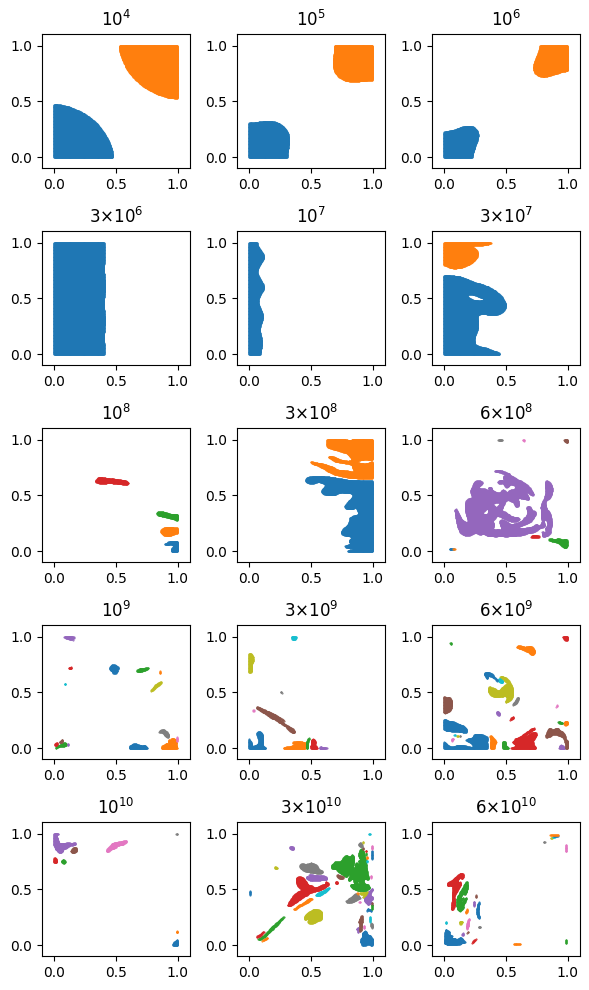

In [125]:
fig = plt.figure(figsize=(6,10))

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)


for b in range(lenRa):
    ax = plt.subplot(5,3, b + 1)
    groups = plume_data_final[b].groupby('class')
    j = 0
    for name, group in groups:
        plt.plot(group[0], group[1], marker='.', linestyle='', ms=1, label=name)
        j+=1
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    ax.set_title('{}'.format(fmt(float(RaU[b]))))
fig.tight_layout()

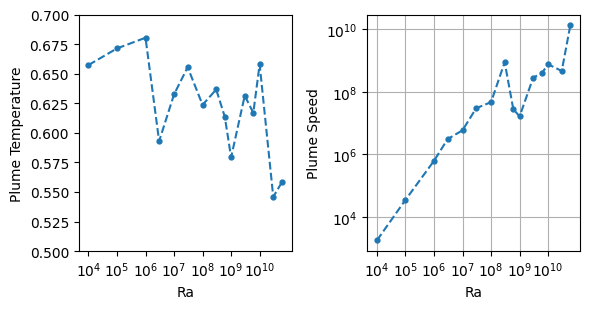

In [126]:
fig = plt.figure(figsize=(6,3.2))

plt.subplot(1,2,1)
plt.rcParams['lines.markersize'] = 7.
plt.plot(plumeDataCluster['Ra'],plumeDataCluster['Mean T'],'.--')
plt.xscale('log');
plt.xlabel('Ra'); plt.ylabel('Plume Temperature');
plt.xticks(np.logspace(4,10,num=7));
plt.ylim(0.5,0.7)

plt.subplot(1,2,2)
plt.plot(plumeDataCluster['Ra'],plumeDataCluster['Speed'],'.--')
plt.xscale('log'); plt.yscale('log');
plt.xlabel('Ra')
plt.ylabel('Plume Speed');
plt.xticks(np.logspace(4,10,num=7));
plt.grid();

fig.tight_layout()